# Nutrient Model

This project is adapted from a "Superproblem" in _Tracers in the Sea_ by Broecker and Peng (1982). Our goal is to understand first-order patterns in marine chemistry by modeling physical and biological nutrient circulation.

Our model consists of four tanks: a simplified analog of the global ocean. The left column is the Indian & Pacific; the right is the Atlantic. Each ocean basin has a small surface tank and a large deep tank. The number on each tank is its volume in liters. Black arrows represent pumps, labeled with flow rates in liters per hour.  These pumps represent the physical circulation of ocean currents. Biological circulation operates differently, and we will need to be creative in how exactly we quantify it. But the key idea is the downward transport of nutrients (green arrows). Let's start with physical circulation only.

<img src="diagram.png" width=500 />


## Model Setup & Physical Circulation

The idea of modeling is to predict the future. We're interested in nutrient concentrations of each tank, which we put in a list $\mathbf{c}$. We want $\mathbf{c}$ as an explicit function of time $t$, but we only know how $\mathbf{c}$ _changes_ over time: let's call this $\mathbf{c}'$. If we can express $\mathbf{c}'$ as a function of $\mathbf{c}$, python will do the rest:
$$\mathbf{c}'=f(\mathbf{c})\underset{\text{python}}{\longrightarrow} \mathbf{c} = g(t)$$
Let's start by modeling the change in nutrient _amounts._ That's a (constant) volume times a change in concentration: $\mathbf{v}\mathbf{c}'$ on the left side of our equation. On the right side, the amount of nutrient in a tank changes exactly as nutrient fluxes in and out; the total change is the influxes minus the outfluxes. To determine nutrient fluxes, we multiply each flow rate $Q$ by its concentration $\mathbf{c}$ (which is conveniently set by its source; concentration of water pumped from A to B matches A). Thus, $\mathbf{v}\mathbf{c}' = Q\mathbf{c}$, or:
$$\mathbf{c}'=f(\mathbf{c})=\boxed{(Q\mathbf{c})/\mathbf{v}}$$
Let's import some libraries and define our function:

In [4]:
import numpy as np # computing
from scipy.integrate import odeint # ordinary differential equations
import matplotlib.pyplot as plt # plots
import seaborn as sns
 
def sys_phys(c, t): # define system
    return Q @ c / v # compute c'

Now let's define the terms. First, let's look at the constant terms $Q$ and $\mathbf{v}$, also known as parameters. $\mathbf{v}$ is a list of volumes. $Q$ is a _matrix_ of flow rates; the entry in row $i,$ column $j$ answers the question: how fast does water from tank $j$ enter tank $i$? This definition is a bit subtle, especially the diagonal terms. Take some time to convince yourself that the product $Q\mathbf{c}$ is really what we want.

In [5]:
# volume
v = [600, 300, 3000, 6000] # L

# h for "hollow" flow matrix (zeros on diagonal). row = sink, column = source
Qh = np.array([[0,  2, 0, 6],
               [8,  0, 4, 0],
               [0, 10, 0, 2],
               [0,  0, 8, 0]]) # L/hr

# complete flow matrix. diagonal entries defined so each column sums to zero
Q = Qh - np.diag(Qh.sum(axis = 0)) # L/hr

print(Q) # compare Q with Qh

[[ -8   2   0   6]
 [  8 -12   4   0]
 [  0  10 -12   2]
 [  0   0   8  -8]]


Meanwhile, $\mathbf{c}$ and $t$ are variables because they change while the model runs. Remember, the point is to predict how variables change over time. So we'll just set initial conditions and a time interval. Let's compute & plot $\mathbf{c}=g(t)$ for phosphate over 5000 model hours.

[A, B, C, D] =  [2. 2. 2. 2.]


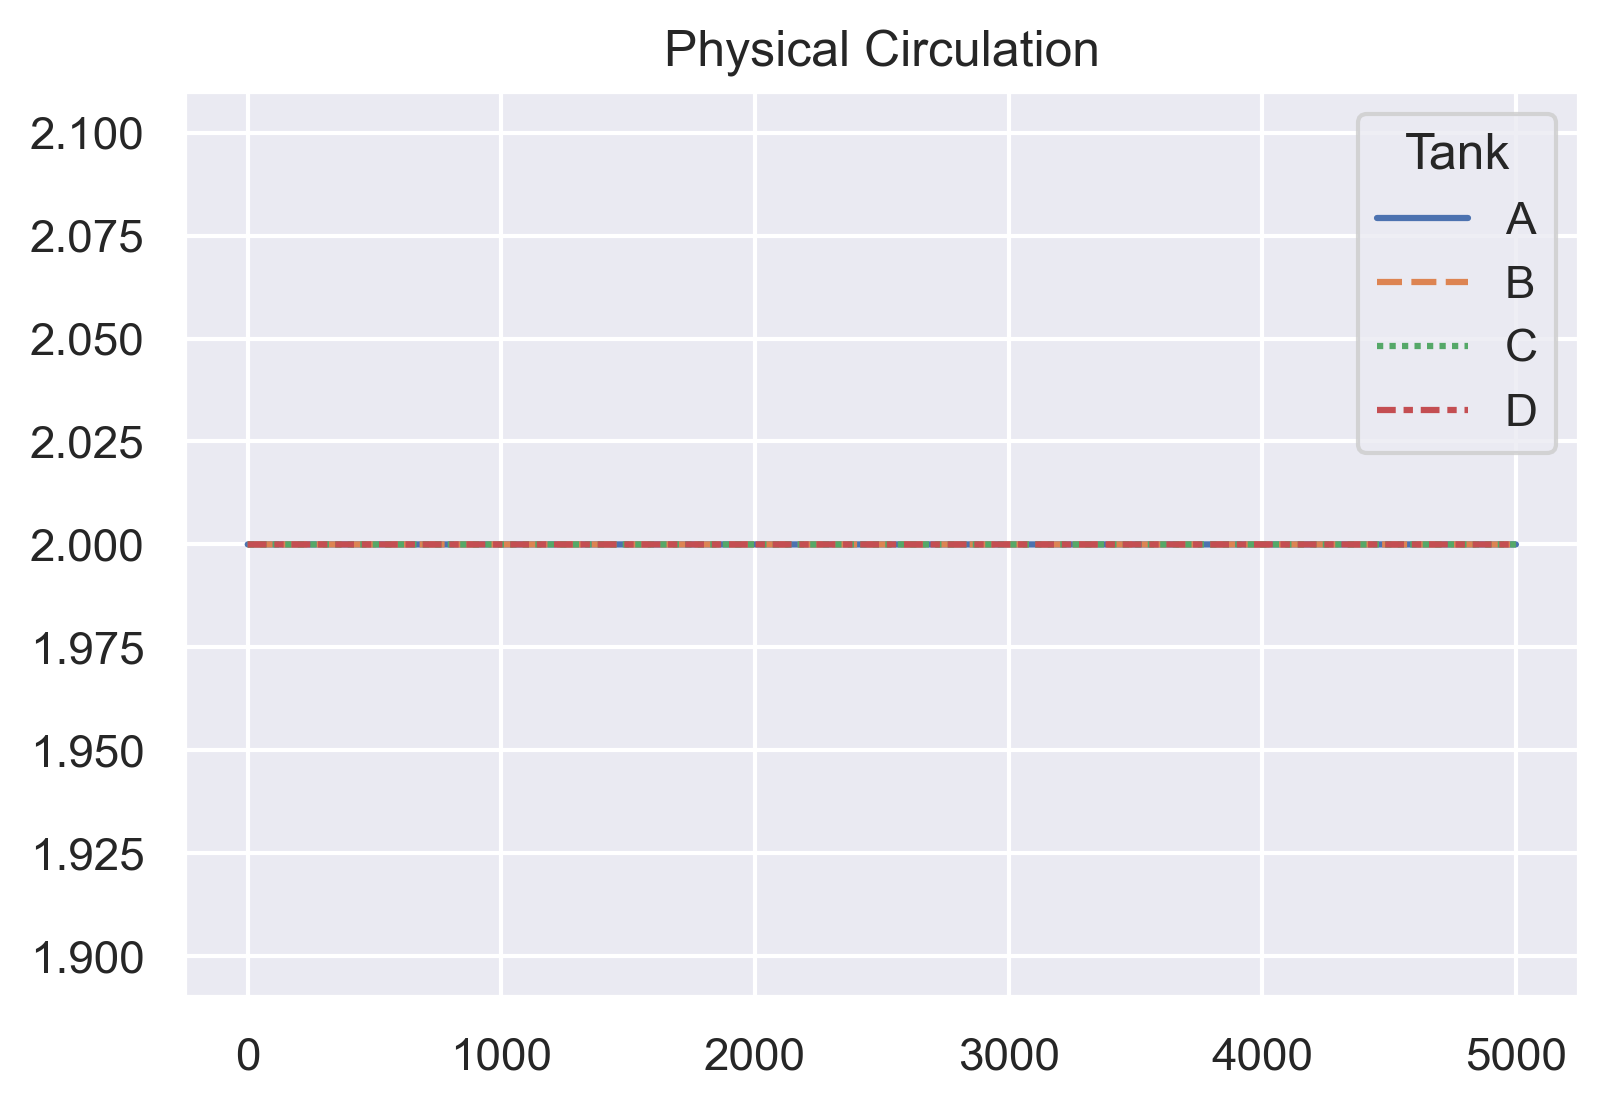

In [6]:
# initial [PO4]
P0 = [2, 2, 2, 2] # umol/L

# time interval
t = np.arange(5000) # hr

# solve sys_abio with c = P0 and t = t ( defined above)
sol_phys = odeint(sys_phys, P0, t)

# default plot settings
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
def legend():
    plt.legend(title="Tank", labels=("A","B","C","D"))

# plot
sns.lineplot(data=sol_phys).set(title="Physical Circulation")
legend()

# show final concentrations (roughly steady state)
print("[A, B, C, D] = ", sol_phys[-1])

Boring! Steady-state from the beginning. Adjust the initial conditions and run the model again. Get a sense for the model behavior before moving on.

## Coupled Physical & Biological Circulation 

Now we include biological circulation. Recall, surface algae need nutrients. When they incorportate phosphate in their tissue, the dissolved amount decreases in the surface tank. When they die, they sink to the deep where heterotrophs consume them and remineralize their nutrients, _increasing_ the dissolved amount in deep tank. The net effect is a nutrient flux from the surface to depth. Let's add this process to our physical circulation model:
$$\mathbf{c}' = f(\mathbf{c}) = \boxed{\left(Q \mathbf{c} + \mathbf{b}\right)/\mathbf{v}}$$
However we define $\mathbf{b}$ for IndoPac and Atlantis, we know the outflux from the surface has to match influx at depth. Here's a function which expresses this constraint, plus a scaling factor $\beta$ we can experiment with:

In [7]:
def bio(beta, indo, atl):
    return beta * np.array([-indo, -atl, atl, indo])

Keep in mind, we are trying to explain real patterns observed in the ocean. Namely, the surface is almost completely devoid of nutrients! So experiment with the models and try to replicate this condition.

### Biological Circulation Set by Surface Concentration

Here we assume $\mathbf{b}$ is proportional to the nutrient concentration at the appropriate surface tank.

[A, B, C, D] =  [0.89534883 0.5755814  1.37500002 2.49418604]


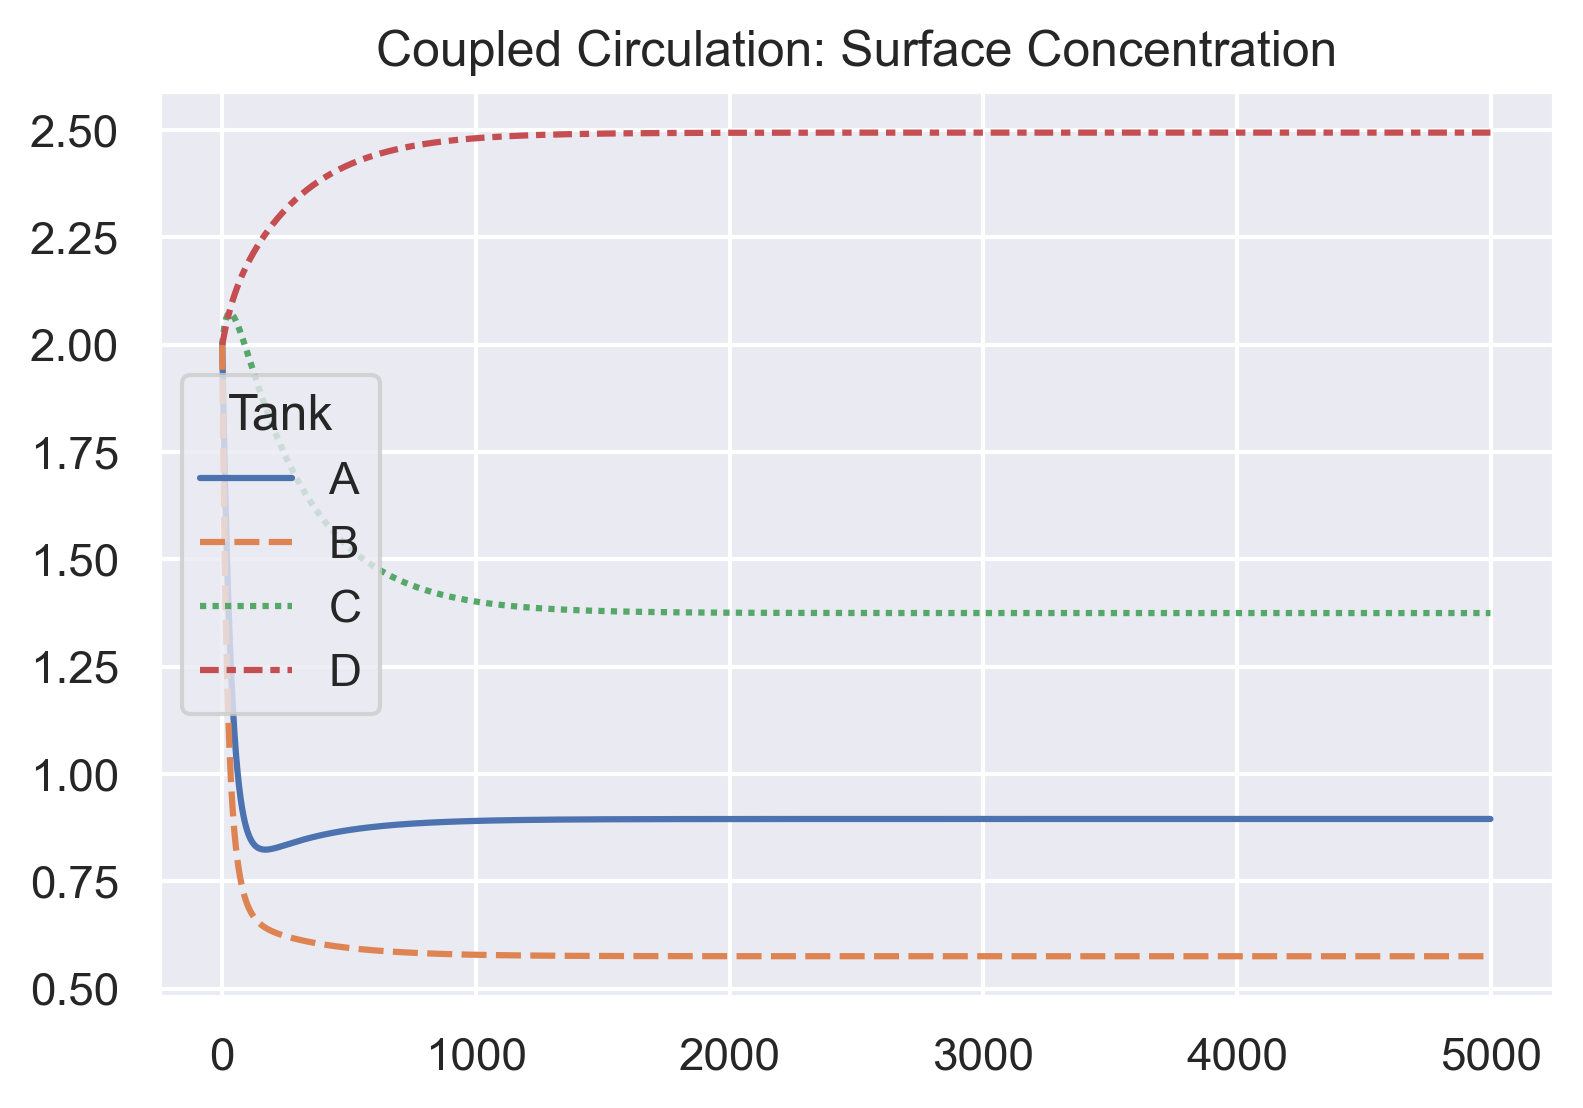

In [8]:
def sys_conc(c, t):
    b = bio(beta_conc, *c[:2]) # c[:2] is the first two terms of c
    return (Q @ c + b) / v

beta_conc = 10 # (L/hr)

sol_conc = odeint(sys_conc, P0, t)

sol_conc_title = "Coupled PO$_4^{3-}$ Cycling: $\mathbf{b} \propto$Surface [PO$_4^{3-}$]"

sns.lineplot(data=sol_conc).set(title="Coupled Circulation: Surface Concentration")
legend()

print("[A, B, C, D] = ", sol_conc[-1])

What $\beta$ values are necessary for both surface tanks to reach equilibrium essentially devoid of nutrient, e.g., less than 0.01 umol/L? Do the two deep tanks reach the same concentration? What about the surface?

### Biological Circulation Set by Surface Influx

Here we assume $\mathbf{b}$ is proportional to the nutrient influx in the appropriate surface tank.

[A, B, C, D] =  [1.17857143 0.78571429 1.57142857 2.35714286]


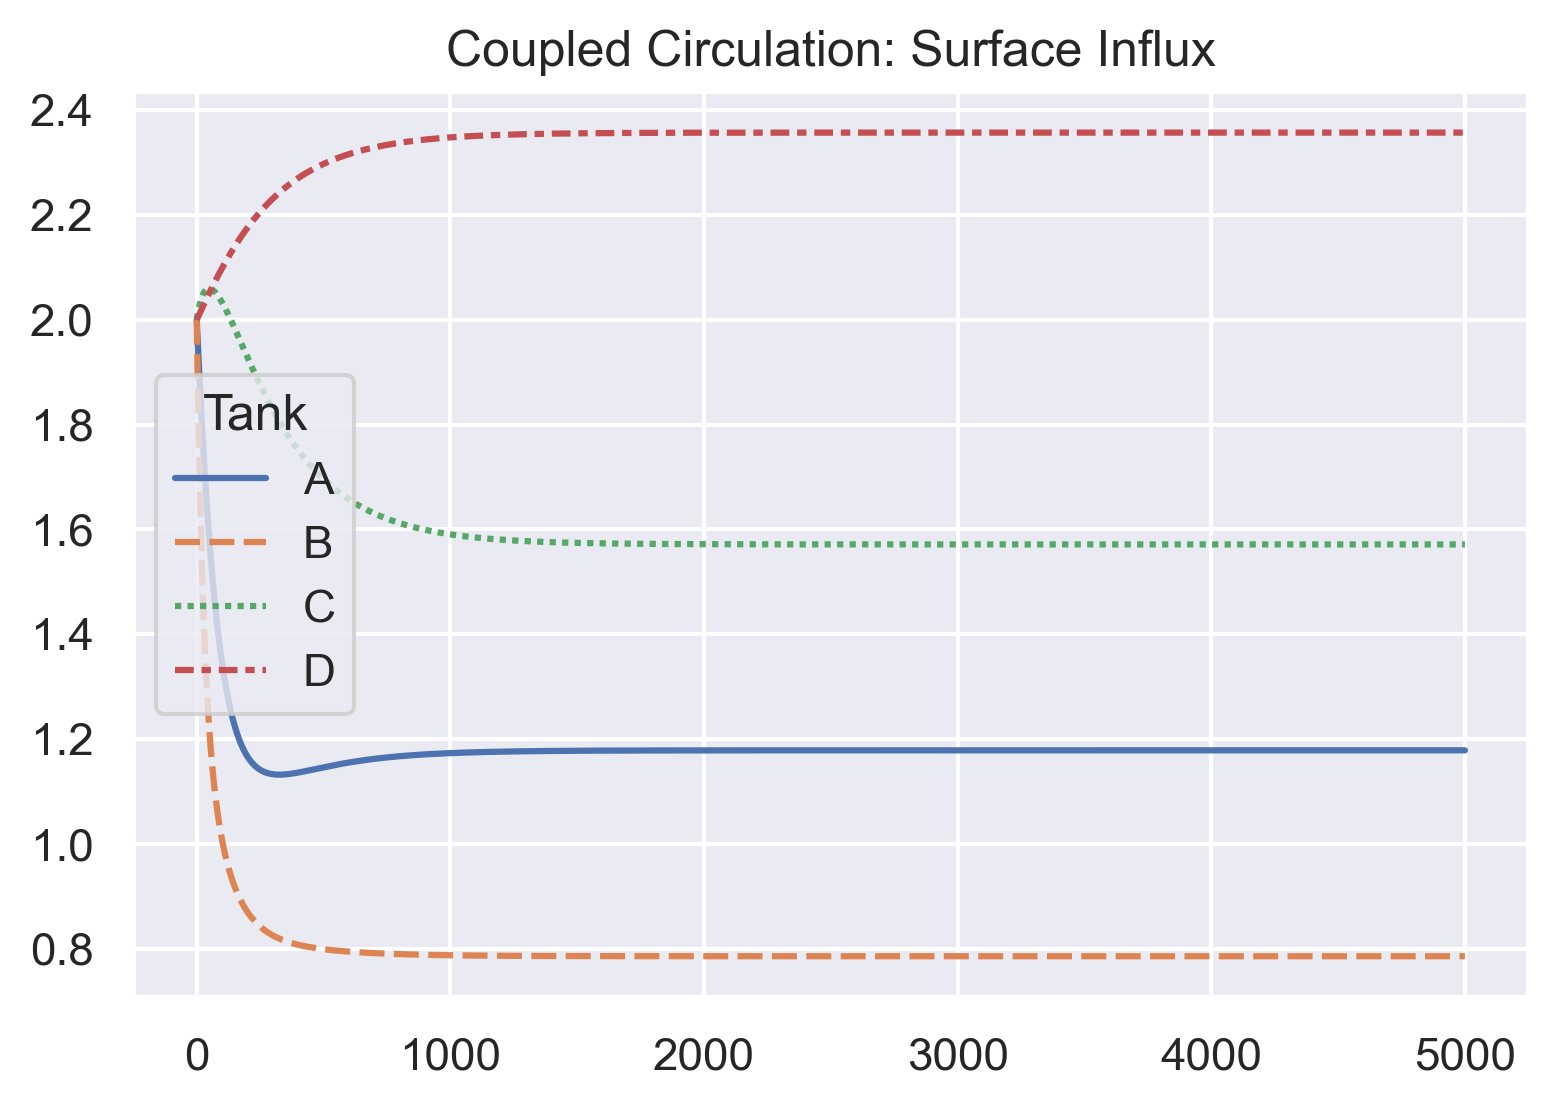

In [9]:
def sys_flux(c, t):
    b = bio(beta_flux, *(Qh[:2] @ c)) # remember Qh?
    return (Q @ c + b) / v

beta_flux = .4

sol_flux = odeint(sys_flux, P0, t)

sns.lineplot(data=sol_flux).set(title="Coupled Circulation: Surface Influx")
legend()

print("[A, B, C, D] = ", sol_flux[-1])

Again, what $\beta$ values are necessary to reach near-zero surface concentrations? What similarities and differences do you notice between the two models?

## Oxygen: Circulation & Gas Exchange

Finally, we model oxygen, whose cycling is linked stoichiometrically to phosphate. Unlike phosphate, oxygen exchanges with the atmosphere at the surface. This process changes concentrations, not amounts, which we reflect in the placement of a new term term $\mathbf{r}$:
$$\mathbf{c}' = f(\mathbf{c}) = \boxed{\left(Q\mathbf{c} + \mathbf{b}\right)/\mathbf{v} + \mathbf{r}}$$
This system is combined with the previous one, since we still need to model phosphate:

[C, D] =  [287.2818476 203.3521174]


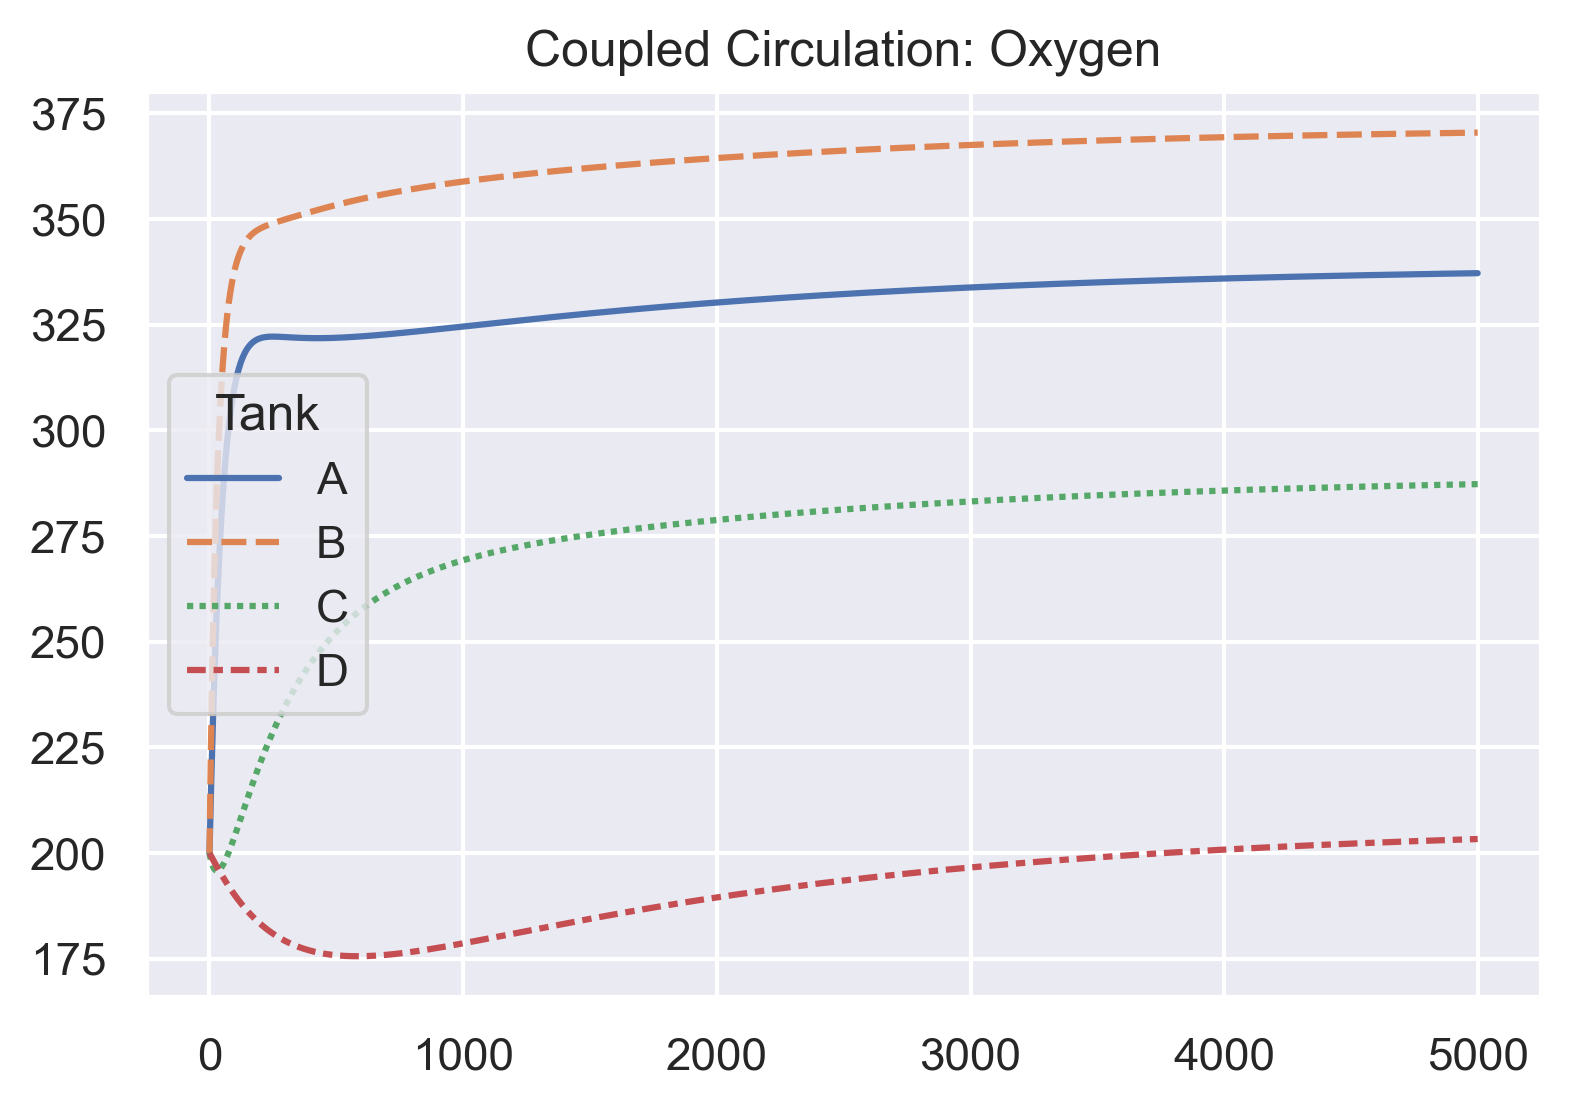

In [10]:
def sys_oxy(c, t):
    b = bio(beta_flux, *(Qh[:2] @ c[:4]))
    r = k_eq * np.array([c_eq - c[4], c_eq - c[5], 0, 0])
    return np.append((Q @ c[:4] + b) / v,
                     (Q @ c[4:] + R * b) / v + r)

R = -105 # Redfield ratio: O2:PO4 in photosynthesis
c_eq = 350 # surface [O2] at atmospheric equilibrium (umol/L)
k_eq = 0.01 # atmospheric equilibration rate constant (/hr)

O0 = [200, 200, 200, 200] # Initial [O2] (umol/L)

sol_oxy = odeint(sys_oxy, np.append(P0, O0), t)

sns.lineplot(data=sol_oxy[:,4:]).set(title="Coupled Circulation: Oxygen")
legend()

print("[C, D] = ", sol_oxy[-1,6:]) # deepwater oxygen concentrations

## Summary

To conclude the activity, write a brief summary essay answering the following questions:

For the physical circulation model, what factors influence the system's initial behavior and long term steady-state conditions? Be sure to interpret any differences you notice in the behavior of the four tanks.

Which definition of the biological flux do you think is a more accurate reflection of real ocean nutrient cycling? Under what spatial or temporal circumstances (if any) would you use these definitions?

Do some cursory research into broad nutrient and oxygen trends in the Atlantic and Pacific oceans. Can this model provide any insight into why these trends might occur?

Include at least three plots in your write-up with documentation of the relevant model assumptions, equations, etc.

BONUS: Explore and evaluate the following models, which duplicate the problem as it was originally posed by Broecker and Peng (1982). They key difference is that the system is not closed; there is an external pump continually supplying water _of a set concentration,_ along with a drain to balance the system. Originally, the flow rates associated with those external components were provided. However, it is possible to calculte what they need to be to maintain constant volume in each tank, given the hollow matrix of internal flow rates like we saw previously. (Find the one term which changed, and check what those external flow rates have to be using print(qe). You can confirm that they match the original problem statement.) What new behaviors do you notice? The first model is purely physical circulation, the second incorporates both a biological pump and oxygen circulation. What does this model capture about the real ocean that our closed system may have missed? Hint: you will need to adjust the time interval...

[A, B, C, D] =  [2. 2. 2. 2.]


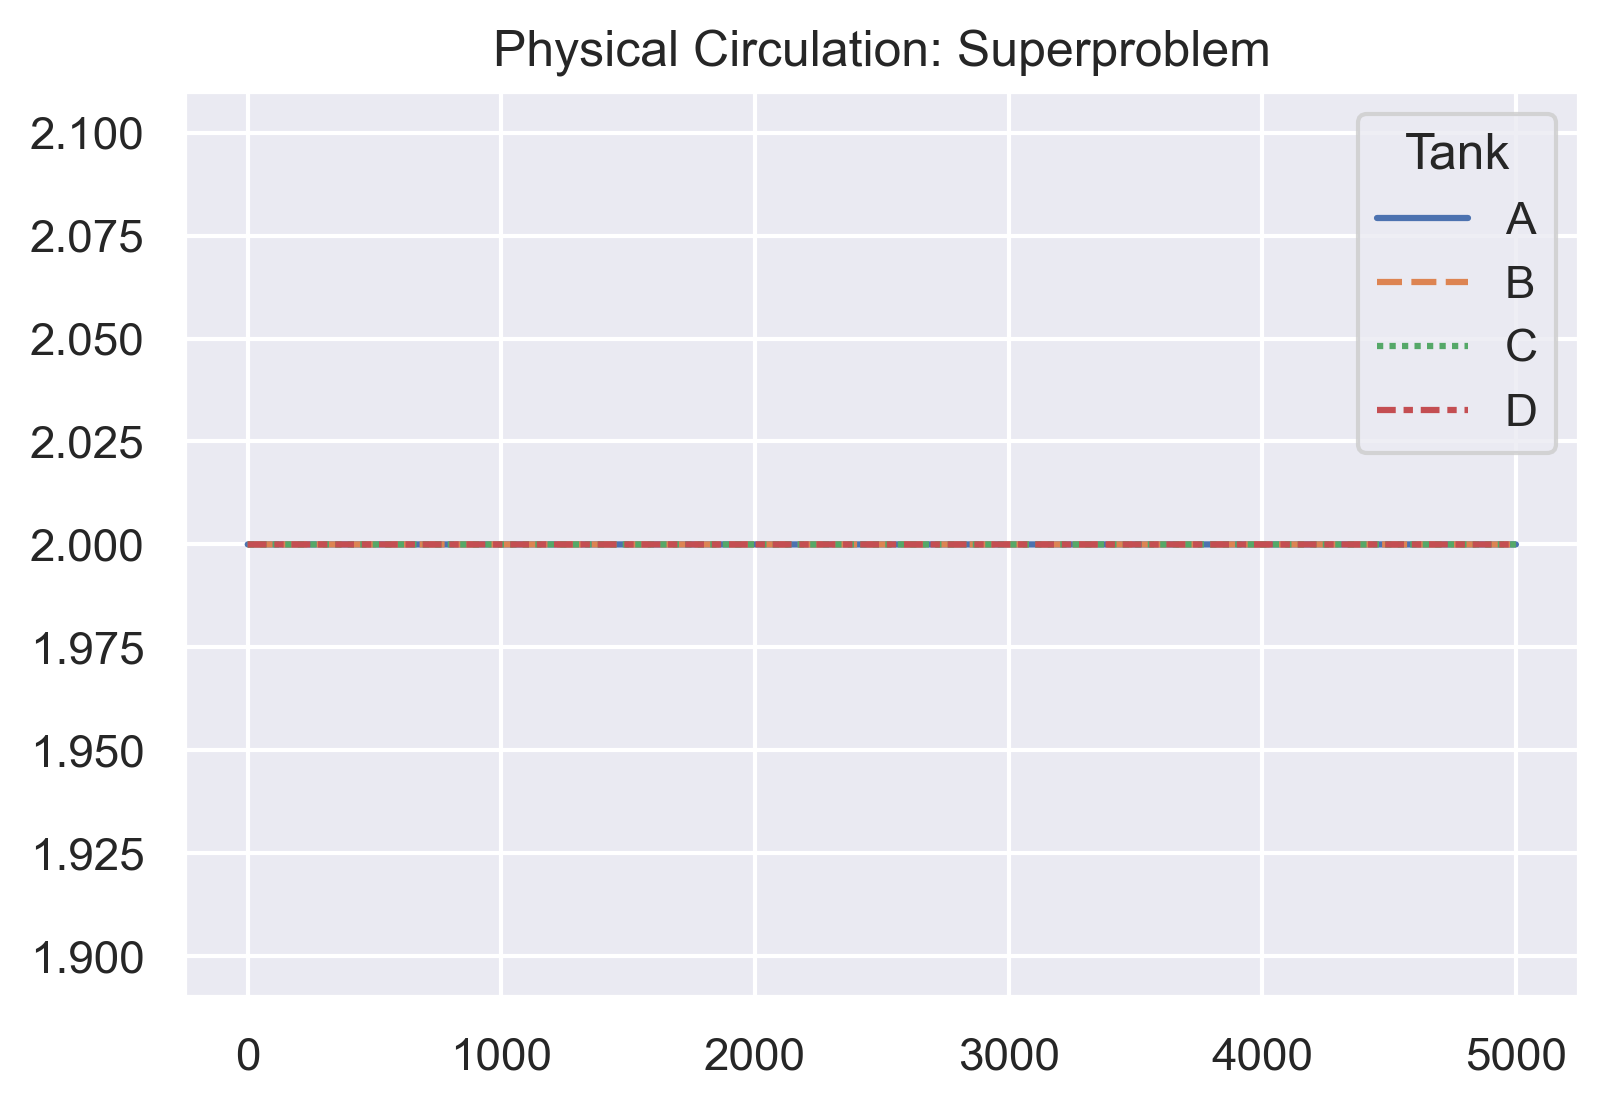

In [11]:
Qhs = np.array([[0,  2, 0, 5], # s for "superproblem" (L/hr)
                [8,  0, 4, 0],
                [0, 10, 0, 2],
                [0,  0, 8, 0]])

qe = Qhs.sum(axis = 0) - Qhs.sum(axis = 1) # external flow rates needed to maintain volume
qi, qo = np.mean([[qe, np.abs(qe)], [qe, -np.abs(qe)]], axis = 1)

Qs = Qhs - np.diag(Qhs.sum(axis = 0)) + np.diag(qo) # L/hr

ci = 2 # external inflow [PO4] (umol/L)

def sys_super(c, t):
    return (Qs @ c + qi * ci) / v

sol_super = odeint(sys_super, P0, t)

sns.lineplot(data=sol_super).set(title="Physical Circulation: Superproblem")
legend()

print("[A, B, C, D] = ", sol_super[-1])

<AxesSubplot:>

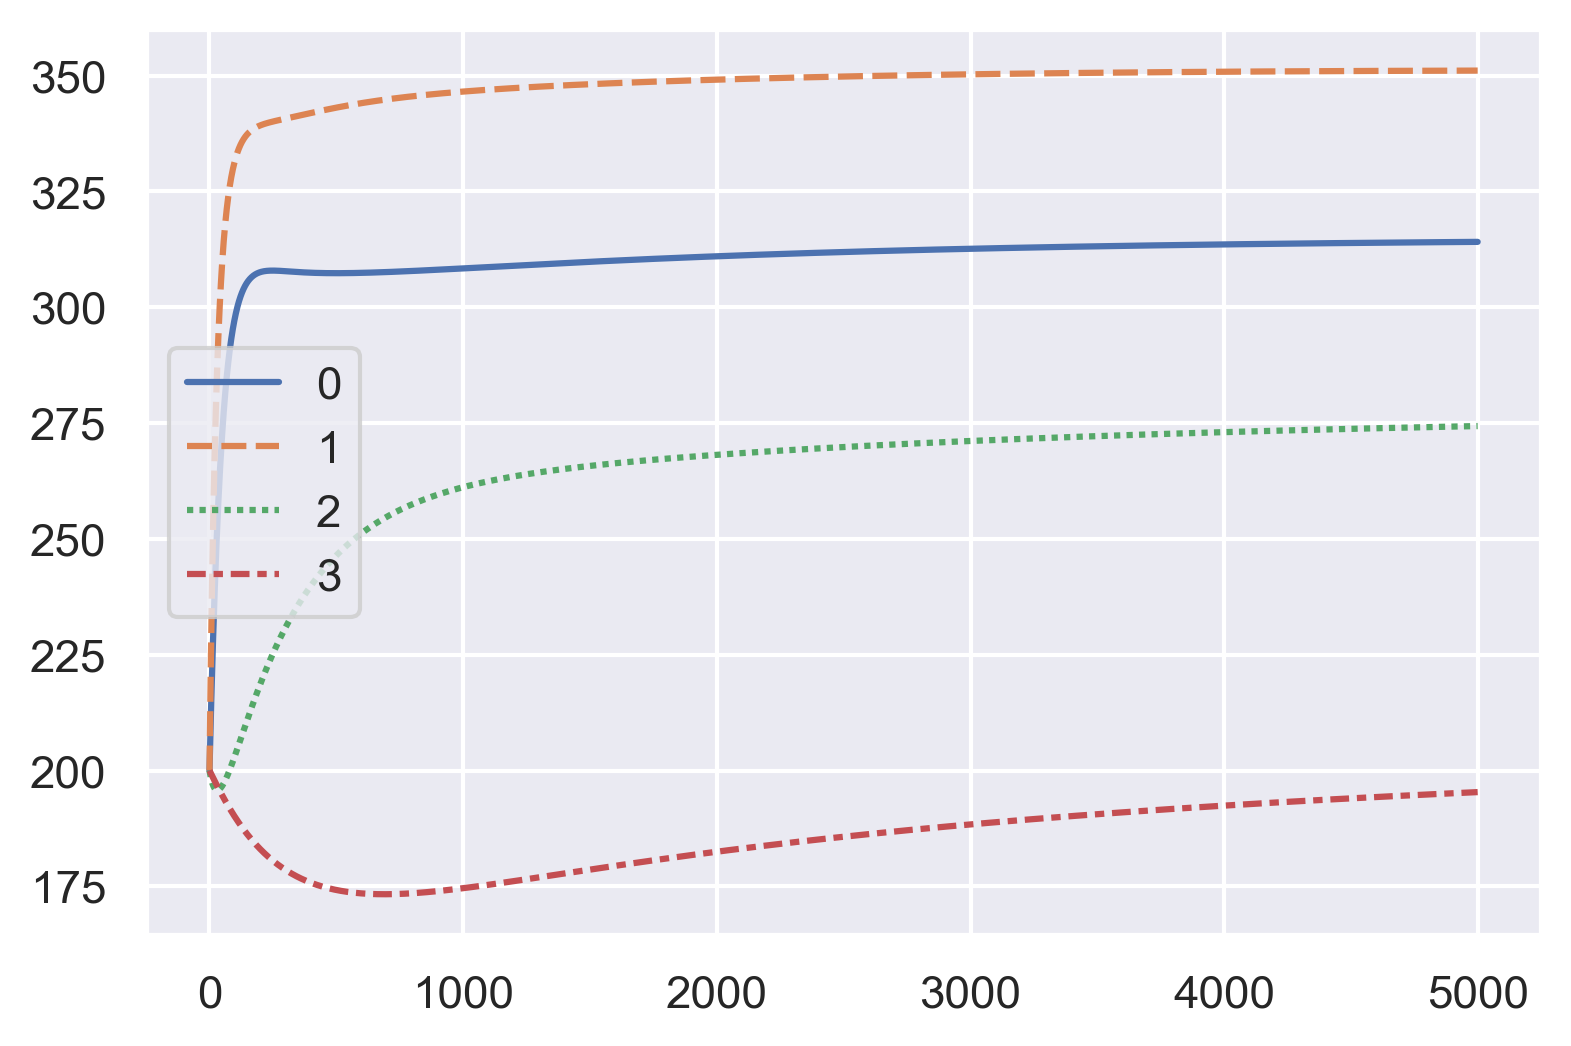

In [12]:
def sys_super_oxy(c, t):
    b = bio(beta_flux, *(Qh[:2] @ c[:4]))
    r = k_eq * np.array([c_eq - c[4], c_eq - c[5], 0, 0])
    return np.append((Qs @ c[:4] + qi * ci + b) / v,
                     (Qs @ c[4:] + qi * ci + R * b) / v + r)

sol_super_oxy = odeint(sys_super_oxy, np.append(P0, O0), t)

sol_super_oxy_title = "Coupled O$_2$ Superproblem: $\mathbf{b} \propto$Surface PO$_4^{3-}$ Influx"

sns.lineplot(data=sol_super_oxy[:,4:])
legend()

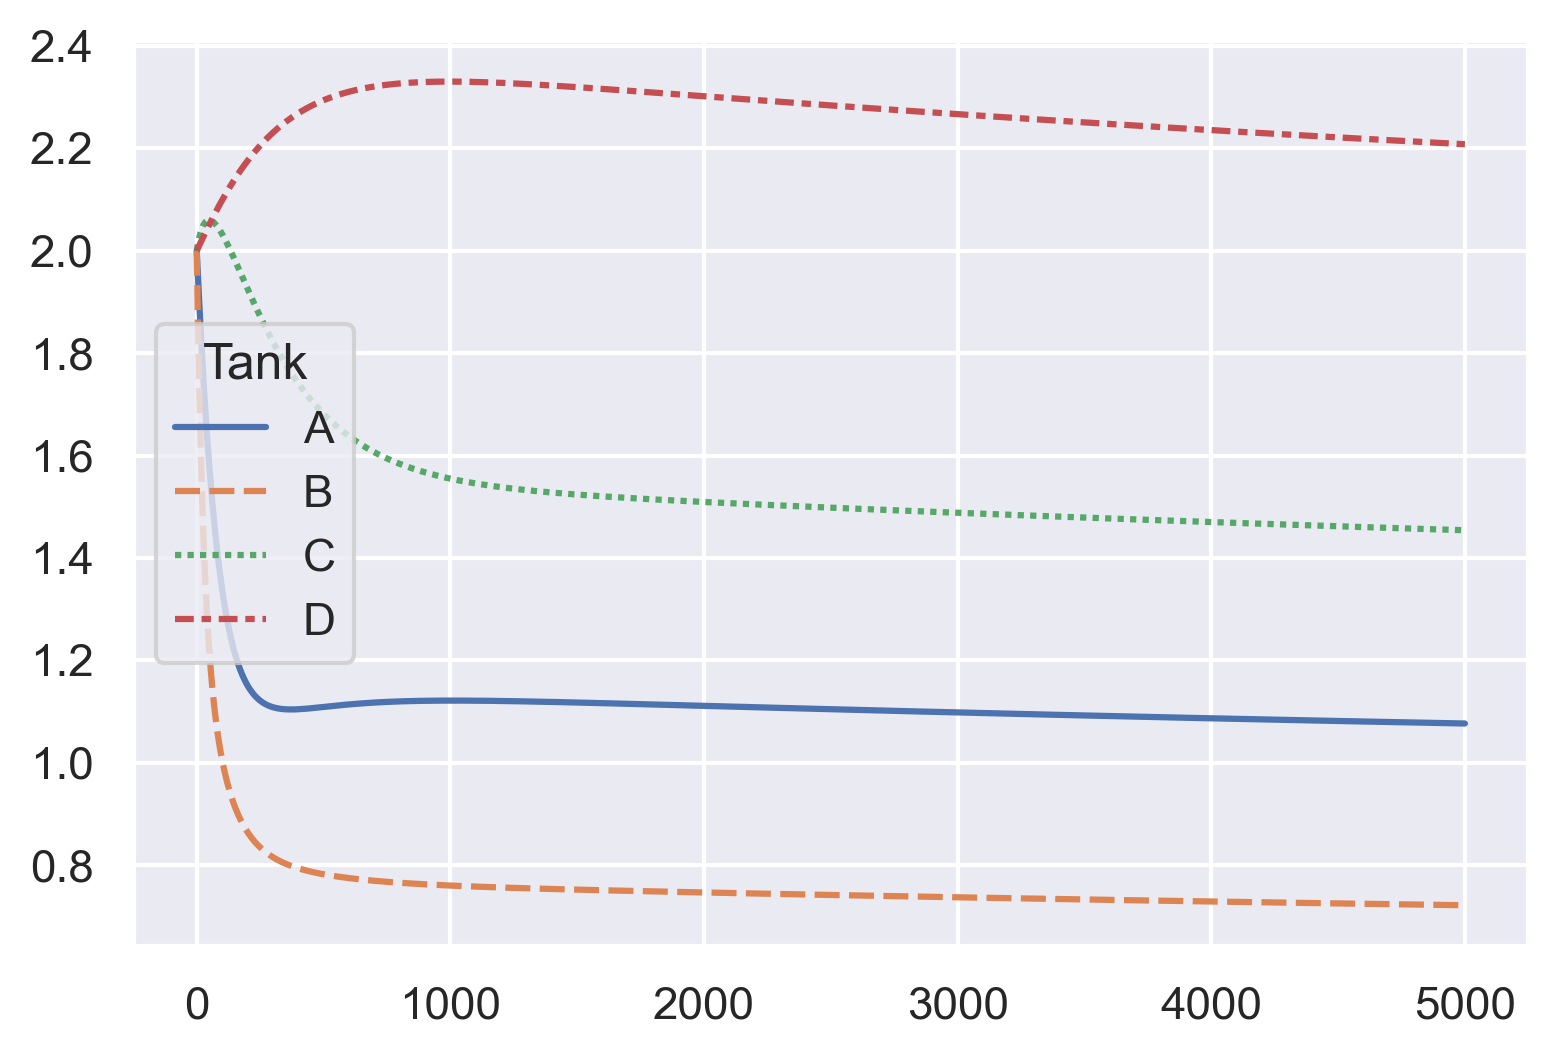

In [14]:
sns.lineplot(data=sol_super_oxy[:,:4])
legend()